# Preprocessing the Data

In [67]:
from tqdm import tqdm_notebook as tqdm
import preprocessor as p
import numpy as np
import pandas
from math import log
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys
import re
from collections import defaultdict, Counter

In [68]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import torch.nn.functional as F

In [69]:
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [70]:
import matplotlib.pyplot as plt
import random

In [71]:
def preprocess(text):
    p.set_options(p.OPT.URL,p.OPT.MENTION,p.OPT.EMOJI,p.OPT.HASHTAG)
    return p.tokenize(text).split()

In [ ]:
data = pandas.read_csv('../')
data

In [72]:
data = pandas.read_csv('../HS_labeled_data.csv')
data

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [73]:
def preprocess(text):
    p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.EMOJI ,p.OPT.HASHTAG)
    return p.tokenize(text).split()

In [74]:
def indexer(split_text):
    sent2idx = []
    for w in split_text:
        if w.lower() in word2idx:
            sent2idx.append(word2idx[w.lower()])
        else:
            sent2idx.append(word2idx['_UNK'])
            
    return sent2idx

In [75]:
train, valid = train_test_split(data)

In [76]:
train

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
15931,16300,3,0,3,0,1,RT @KINGTUNCHI_: You bitches ain't a #100
21296,21757,6,0,6,0,1,Teacher: You had all weekend to do you homewor...
13070,13390,3,2,1,0,0,My managers a stupid cunt yes I said it
3752,3860,3,0,3,0,1,@KR3TZ3R15 Idk is she's actually from there lo...
18826,19243,6,0,6,0,1,RT @daijahshardaee: &#8220;@100046729: I need ...
...,...,...,...,...,...,...,...
12725,13042,3,0,3,0,1,Man I'm tired of dealing with these hoes but m...
15377,15740,3,1,2,0,1,RT @GreatNegrodamus: Lmfaoooooooooo trash ass ...
11305,11594,3,0,3,0,1,I'm just not going to be a bitch to you becaus...
17099,17489,3,1,2,0,1,RT @RickyNgan: These hoes is thotful


In [82]:
train['clean_text'] = train.tweet.apply(lambda x: preprocess(x.lower().strip()))

words = Counter()
for sent in tqdm(train.clean_text.values):
    words.update(w.lower() for w in sent)
   
# sort with most frequently occuring words first
words = sorted(words, key=words.get, reverse=True)
# add <pad> and <unk> token to vocab which will be used later
words = ['_PAD','_UNK'] + words

word2idx = {o:i for i,o in enumerate(words)}
idx2word = {i:o for i,o in enumerate(words)}

train['sentence2idx'] = train.clean_text.apply(lambda x: indexer(x))
train['length'] = train.clean_text.apply(lambda x: len(x))
train['label'] = train['class'].apply(lambda x: int(bool(x)))

/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 18587/18587 [00:00<00:00, 135623.77it/s]
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-pack

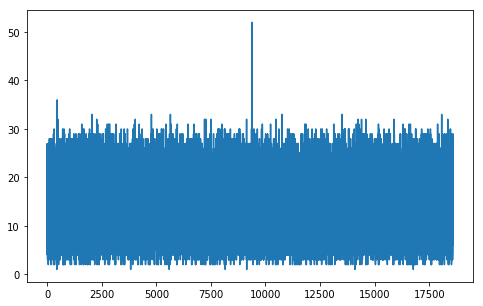

In [83]:
fig = plt.figure(figsize=(8,5))
ax = plt.plot(train.length.values)
plt.show()

In [88]:
valid['clean_text'] = valid.tweet.apply(lambda x: preprocess(x.strip()))

valid['sentence2idx'] = valid.clean_text.apply(lambda x: indexer(x))
valid['length'] = valid.clean_text.apply(lambda x: len(x))
valid['label'] = valid['class'].apply(lambda x: int(bool(x)))

/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_lau

In [89]:
class VectorizeData(Dataset):
    def __init__(self, df, maxlen=30):
        self.maxlen = maxlen
        self.df = df
#         print('Padding')
        self.df['padded_text'] = self.df.sentence2idx.apply(lambda x: self.pad_data(x))
        self.padded_text = list(self.df.padded_text)
        self.labels = list(self.df.label)
        self.lengths = list(self.df.length)
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
#         lens = self.df.length[idx]
        X = self.padded_text[idx]
        y = self.labels[idx]
        lens = self.lengths[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded

In [90]:
train_loader = VectorizeData(train)
valid_loader = VectorizeData(valid)

/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [91]:
tl = DataLoader(dataset=train_loader, batch_size=100, shuffle=True)
print(len(tl))

186


In [92]:
vl = DataLoader(dataset=valid_loader, batch_size=100, shuffle=False)
print(len(vl))

62


In [93]:
for i, samples in enumerate(tl):
    print(i)
    print(samples)
    break

0
[tensor([[   4,    5,   39,  ...,   30,    0,    0],
        [ 569,   95,   35,  ...,    0,    0,    0],
        [   2,  144,  236,  ...,    0,    0,    0],
        ...,
        [  33,  510,   19,  ...,    0,    0,    0],
        [ 797, 5433, 5434,  ...,    0,    0,    0],
        [   4,    5,   12,  ...,    0,    0,    0]]), tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1]), tensor([28,  8,  3, 24, 17,  5,  9, 12, 21, 27,  5, 23,  2, 24,  8, 18, 11, 15,
        19, 19, 15, 26, 20, 27, 23,  6,  9, 22,  7, 11, 19,  7, 14, 23,  5,  6,
         9,  6, 25,  7, 29,  8, 10,  7, 23,  9,  3, 17, 16,  9, 11, 22, 26, 11,
        22,  7, 20, 11, 28, 25, 18,  9,  9, 16, 22,  9, 12, 13, 17,  5,  4, 19,
        

In [94]:
for i, samples in enumerate(vl):
    print(i)
    print(samples)
    break

0
[tensor([[    6,    52, 22226,  ...,     0,     0,     0],
        [   33,   105,  1692,  ...,     0,     0,     0],
        [    2,   517,     9,  ...,     0,     0,     0],
        ...,
        [    2,    10,   323,  ...,     0,     0,     0],
        [ 7299,    72,    64,  ...,     0,     0,     0],
        [   98,    12,  2531,  ...,     0,     0,     0]]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1]), tensor([10, 24,  6,  7, 18, 16, 10,  5, 24, 11,  5,  9,  6,  7, 17, 18, 17,  5,
         8, 24,  5,  7, 21, 10,  9,  7, 20, 25, 13, 16,  7, 21, 11,  9, 11,  8,
        16, 16, 13,  8,  6, 15,  9,  6, 13, 13, 12, 21, 13,  9, 22, 15,  4, 21,
        10, 19,  9, 21, 17, 23, 14, 16,  4,  5, 11, 

## RecModel

In [95]:
class RecArch(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidir, rnnType,device):
        super(RecArch, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = device
        self.rnnType = rnnType
        self.bidirectional = bidir
        
        if self.bidirectional:
            self.numDirs = 2
        else:
            self.numDirs = 1
        
        self.emb = nn.Embedding(self.vocab_size, embedding_dim)
        
        if self.rnnType == 'lstm':
            self.recNN = nn.LSTM(embedding_dim,hidden_dim, num_layers,batch_first=True,bidirectional=self.bidirectional)
            
        if self.rnnType == 'gru':
            self.recNN = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True,bidirectional=self.bidirectional)
            
        if self.rnnType == 'rnn':
            self.recNN = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True, nonlinearity='tanh',bidirectional=self.bidirectional)
        
        self.fc = nn.Linear(self.numDirs*hidden_dim,output_dim)
    
    def encode(self,x):
        embs = self.emb(x)
        embs = embs.view(x.size(0),-1,self.embedding_dim).to(self.device)
        
        h0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
        
        if self.rnnType == 'lstm':        
            c0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
            
            out,(hn,cn) = self.recNN(embs,(h0,c0))
        
        else:
            out, hn = self.recNN(embs, h0)
        
#         print(out[:,-1,:].shape)
        return out[:, -1, :]
    
    def forward(self,x):
        embs = self.emb(x)
        embs = embs.view(x.size(0),-1,self.embedding_dim).to(self.device)
        
        h0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
        
        if self.rnnType == 'lstm':        
            c0 = Variable(torch.zeros(self.numDirs*self.num_layers,x.size(0),self.hidden_dim),requires_grad=True).to(self.device)
            
            out,(hn,cn) = self.recNN(embs,(h0,c0))
        
        else:
            out, hn = self.recNN(embs, h0)
        
#         print(out[:,-1,:].shape)
        out = self.fc(out[:, -1, :])
        return out

### Optimal combination seems to be with GRU of 50 units and 1 layer

In [148]:
vocab_size = len(words)
embedding_dim = 256
n_hidden = 50
n_out = 2
num_layers = 1
rnnType = 'rnn'
bidir = False

if torch.cuda.is_available():
    device = 'cuda:1'
else:
    device = 'cpu'

In [149]:
model = RecArch(vocab_size,embedding_dim,n_hidden,n_out,num_layers,bidir,rnnType,device)
model = model.to(device)
model.float()

RecArch(
  (emb): Embedding(27644, 256)
  (recNN): RNN(256, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

# Pretraining Text Encoder

In [150]:
optimizer = torch.optim.Adagrad(model.parameters(),lr=0.01)
# criterion = torch.nn.BCEWithLogitsLoss()
criterion = torch.nn.CrossEntropyLoss()

seq_dim = 30
num_epochs = 200

train_losses_iterwise = []
recall_iterwise = []
precision_iterwise = []
accuracy_iterwise = []
f1score_iterwise = []
val_losses_iterwise = []

for epoch in tqdm(range(num_epochs)):
    train_losses = []
    val_losses = []
    for i, (text,label,lengths) in enumerate(tl):

        text = Variable(text.view(-1, seq_dim, 1)).to(device)
        label = Variable(label).to(device)
        
#         print(sexism_label)
        
        optimizer.zero_grad()
        outputs = model(text)
        
#         print(outputs)
        
        loss = criterion(outputs, label)
        train_losses.append(loss.data.cpu())
        
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        correct = 0
        total = 0

        allLabels = []
        allPreds = []
        probPreds = []

        for i, (text,label,lengths) in enumerate(vl):
            labels=[]
            text = Variable(text.view(-1, seq_dim, 1)).to(device)
            label = Variable(label).to(device)

            predicted = model(text)
            predicted =  torch.softmax(predicted,1)
            probPreds.append(predicted)
            predicted = torch.max(predicted, 1)[1].cpu().numpy().tolist()
    #                 print(predicted)
    #                 print(sexism_label)
            allLabels += (label.cpu().numpy().tolist())
            allPreds += (predicted)

        valacc = accuracy_score(allLabels, allPreds)
        recscore = recall_score(allLabels, allPreds,average='macro')
        precscore = precision_score(allLabels, allPreds,average='macro')
        f1score = f1_score(allLabels, allPreds,average='macro')
        roc = roc_auc_score(allLabels,allPreds)
        cr = classification_report(allLabels, allPreds)
        print(f'acc: {valacc} AUC {roc}')
        print(cr)

        train_losses_iterwise.append(np.mean(train_losses))


  0%|          | 1/200 [00:01<03:39,  1.10s/it]

acc: 0.9431891542930924 AUC 0.49931647300068355
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       344
           1       0.94      1.00      0.97      5852

   micro avg       0.94      0.94      0.94      6196
   macro avg       0.47      0.50      0.49      6196
weighted avg       0.89      0.94      0.92      6196




 25%|██▌       | 50/200 [00:41<02:02,  1.23it/s]/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/nikhil.pinnaparaju/anaconda3/envs/fakenews/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

 26%|██▌       | 51/200 [00:42<02:08,  1.16it/s]

acc: 0.9444803098773402 AUC 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       344
           1       0.94      1.00      0.97      5852

   micro avg       0.94      0.94      0.94      6196
   macro avg       0.47      0.50      0.49      6196
weighted avg       0.89      0.94      0.92      6196




 50%|█████     | 101/200 [01:23<01:25,  1.16it/s]

acc: 0.9443189154293092 AUC 0.4999145591250854
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       344
           1       0.94      1.00      0.97      5852

   micro avg       0.94      0.94      0.94      6196
   macro avg       0.47      0.50      0.49      6196
weighted avg       0.89      0.94      0.92      6196




 76%|███████▌  | 151/200 [02:04<00:42,  1.15it/s]

acc: 0.9443189154293092 AUC 0.4999145591250854
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       344
           1       0.94      1.00      0.97      5852

   micro avg       0.94      0.94      0.94      6196
   macro avg       0.47      0.50      0.49      6196
weighted avg       0.89      0.94      0.92      6196




100%|██████████| 200/200 [02:44<00:00,  1.22it/s]


# Identifying BSWs

In [101]:
dixon_bsws = ['lesbian', 'gay', 'bisexual', 'transgender', 'trans', 'queer', 'lgbt', 'lgbtq', 'homosexual', 'straight', 'heterosexual', 'male', 'female', 'nonbinary',
'african', 'african american', 'black', 'white', 'european', 'hispanic', 'latino', 'latina', 'latinx', 'mexican', 'canadian', 'american', 'asian', 'indian',
'middle eastern', 'chinese', 'japanese', 'christian', 'muslim', 'jewish', 'buddhist', 'catholic', 'protestant', 'sikh', 'taoist', 'old', 'older', 'young',
'younger', 'teenage', 'millenial', 'middle aged', 'elderly', 'blind', 'deaf', 'paralyzed']

In [102]:
bsws = {}
for word in tqdm(word2idx):
    vect = torch.tensor([word2idx[word]]).to(device)
    textenc = model.encode(vect)
    scores = torch.softmax(model.fc(textenc),1)
    
    if torch.max(scores) > 0.7 and torch.argmax(scores) == 0:
        bsws[word] = torch.max(scores).item()


 61%|██████    | 16891/27644 [00:13<00:08, 1205.58it/s]


100%|██████████| 27644/27644 [00:22<00:00, 1207.71it/s]


In [103]:
bsws

{'_PAD': 0.9863454699516296,
 'on': 0.8962116241455078,
 'but': 0.7399446368217468,
 'when': 0.714991569519043,
 'fuck': 0.7501645088195801,
 'u': 0.7753323912620544,
 'was': 0.7422361969947815,
 'at': 0.7287482619285583,
 'about': 0.9882065653800964,
 "it's": 0.748506486415863,
 'want': 0.8519607186317444,
 'yo': 0.867633044719696,
 'im': 0.8452352285385132,
 'see': 0.7921975255012512,
 'back': 0.8713554739952087,
 'girl': 0.9109686017036438,
 'white': 0.7899085879325867,
 'gotta': 0.9096128344535828,
 'dont': 0.896612823009491,
 'here': 0.9383516907691956,
 'damn': 0.8123378753662109,
 'ugly': 0.9091417193412781,
 'am': 0.752495527267456,
 'much': 0.769209623336792,
 "he's": 0.7270351648330688,
 'before': 0.7461113929748535,
 'fag': 0.9075984954833984,
 'trash.': 0.913714587688446,
 'tryna': 0.7695583701133728,
 'next': 0.710404098033905,
 'smh': 0.9827638864517212,
 'stay': 0.7701802849769592,
 'hoe.': 0.7369174957275391,
 'name': 0.8709725141525269,
 'ima': 0.7519470453262329,
 "wo

In [124]:
def testModelClassification(sentence):
    tokens = preprocess(sentence.lower().strip())
    output = model(torch.tensor([word2idx[x] for x in tokens]).reshape(1,-1).to(device))
    return torch.softmax(output,dim=1)

In [105]:
def SOAC(listOfTokenizedSentences, listOfLabels):
    tfs = defaultdict(lambda:0)
    dfs = defaultdict(lambda:0)
    df_pos = defaultdict(lambda:0)
    df_neg = defaultdict(lambda:0)
    
    for i in range(len(listOfTokenizedSentences)):
        sent = listOfTokenizedSentences[i]
        wordCounts = Counter(sent)
        
        for word in wordCounts:
            tfs[word] += wordCounts[word]
            dfs[word] += 1
            
            if listOfLabels[i] == 0:
                df_pos[word] += 1
            if listOfLabels[i] == 2:
                df_neg[word] += 1
                
    return tfs,dfs,df_pos,df_neg

In [106]:
def getSOAC_BSWs(tfs,dfs,df_pos,df_neg,threshold):
    bsws = []
    for key in list(tfs.keys()):
        if tfs[key] > threshold and df_pos[key] > df_neg[key]:
            bsws.append(key)
    return bsws

In [107]:
tfs,dfs,df_pos,df_neg = SOAC(list(train['clean_text']),list(train['class']))
bsws = getSOAC_BSWs(tfs,dfs,df_pos,df_neg,25)

In [108]:
bsws

['bitches',
 'bitch',
 'stupid',
 'cunt',
 'swear',
 'bitch,',
 'u',
 'acting',
 'bitch"',
 'pussy',
 'ass',
 'nigga',
 'ur',
 'hoe',
 'fucking',
 'faggot.',
 'broke',
 'niggas',
 'mind',
 'hoes',
 'white',
 "y'all",
 'quit',
 'fake',
 'fuck',
 'cause',
 'yo',
 'lmaoo',
 'racist',
 'nigger',
 'bitch.',
 'bitch?',
 'shit.',
 'shit',
 'aint',
 'dirty',
 'dumb',
 'ya',
 'boy',
 'pull',
 'faggot',
 'shut',
 'fag',
 'niccas',
 'everyday',
 'dyke',
 'gay',
 'niggers',
 'niggah',
 'stfu',
 'bitch!',
 'dad',
 'jus',
 'tired',
 'hoes,',
 'kill',
 'yourself',
 'ugly',
 'own',
 'hoe.',
 'hate',
 'fucked',
 'wow',
 'dat',
 'none',
 'bitches.',
 'speak',
 'talking',
 'retard',
 'knows',
 'naw',
 'women',
 'me,',
 'forget',
 'fuckin',
 'likes',
 'boyfriend',
 'smh',
 'fat',
 '"',
 'fight',
 'crying',
 'hood',
 'retarded',
 'niggaz',
 'nigga,',
 'bruh',
 'followers',
 'outta',
 'cut',
 'talkin',
 'dey',
 'mf',
 'pussy.',
 'feelings',
 'grow',
 'tf',
 'chick',
 'pussies',
 'dick',
 'nig',
 'nigguh',
 

### Bias Examples

In [135]:
testModelClassification('nig')

tensor([[0.7820, 0.2180]], device='cuda:1', grad_fn=<SoftmaxBackward>)

In [126]:
testModelClassification('kat is a woman')

tensor([[0.0557, 0.9443]], device='cuda:1', grad_fn=<SoftmaxBackward>)

In [127]:
testModelClassification('john is a woman')

tensor([[0.0043, 0.9957]], device='cuda:1', grad_fn=<SoftmaxBackward>)

# Pinned Bias Metrics

In [136]:
def pinned_bias(listOfProbabilities, threshold_type, num_classes=3):
    prob_hateful = listOfProbabilities
#     print(listOfProbabilities)
    
    if threshold_type == 'mean':
        pb = np.absolute(prob_hateful).sum() / len(listOfProbabilities)
        
    if threshold_type == 'sym':
        num = np.array(prob_hateful) - 1/num_classes
        pb = np.absolute(num).sum() / len(listOfProbabilities)
        
    if threshold_type == 'asym':
        num = np.array(prob_hateful) - np.array([min(x,0.5) for x in prob_hateful])
        pb = np.absolute(num).sum() / len(listOfProbabilities)
    
    return pb

In [151]:
hatefulProbsOfBSWs = [testModelClassification(word)[0][0].item() for word in bsws]

In [152]:
print(pinned_bias(hatefulProbsOfBSWs,'mean'))
print(pinned_bias(hatefulProbsOfBSWs,'sym'))
print(pinned_bias(hatefulProbsOfBSWs,'asym'))

0.32303087846484296
0.17039946339620177
0.030647830907688585
